Important note: This project utilized a vm instance with 64gb of ram in order to function properly.

In [1]:
#Generic Imports for the moment

%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import patsy
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import sklearn.neighbors
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys

#Note, initally loading the train data alone took approximately 5-6gb of ram

# Loading The Data

The method below was suggested in various sources. This is the first source where I saw it suggested https://www.kaggle.com/theoviel/load-the-totality-of-the-data. Certain data types are changed when loaded in order to save space. This was required to use on my local machine. Train data was slimmed down to 1.9gb and test was slimmed down to 1.6gb (still bulky but useable).

In [2]:
#Change data types to reduce space. Total memory usage drops to 3.6gb
#utilized one of the suggestions on the notebooks to cut down on loading/storage. 
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
train_df = pd.read_csv('train.csv', dtype=dtypes)
test_df = pd.read_csv('test.csv', dtype=dtypes)


# Data Clean Up

So my original idea was to cut down as much data as possible and fit to a linear regression model. This eventually switched to using a random forest model, but initally I was searching for ways to cut down on useless data. This started by finding columns with large amounts of missing data. Portions of my clean up and EDA intertwin at times, but I've attempted to clarify each section separately in regards to the rubric.

In [4]:
total = train_df.isnull().sum()

In [5]:
#Examine which columns are missing significant chunks of data.
rows = holder = total / 8921483
total.sort_values()
#Percentage missing
holder = total / 8921483
print(holder.sort_values().tail(25))

Census_PrimaryDiskTotalCapacity            0.005943
IeVerIdentifier                            0.006601
Census_OSInstallLanguageIdentifier         0.006735
Census_IsAlwaysOnAlwaysConnectedCapable    0.007997
Census_TotalPhysicalRAM                    0.009027
Firewall                                   0.010239
Census_OEMNameIdentifier                   0.010702
Census_OEMModelIdentifier                  0.011459
Census_FirmwareVersionIdentifier           0.017949
Census_IsFlightsDisabled                   0.017993
Census_FirmwareManufacturerIdentifier      0.020541
Census_InternalBatteryNumberOfCharges      0.030124
Wdft_RegionIdentifier                      0.034014
Wdft_IsGamer                               0.034014
CityIdentifier                             0.036475
SMode                                      0.060277
OrganizationIdentifier                     0.308415
SmartScreen                                0.356108
Census_IsWIMBootEnabled                    0.634390
Census_Thres

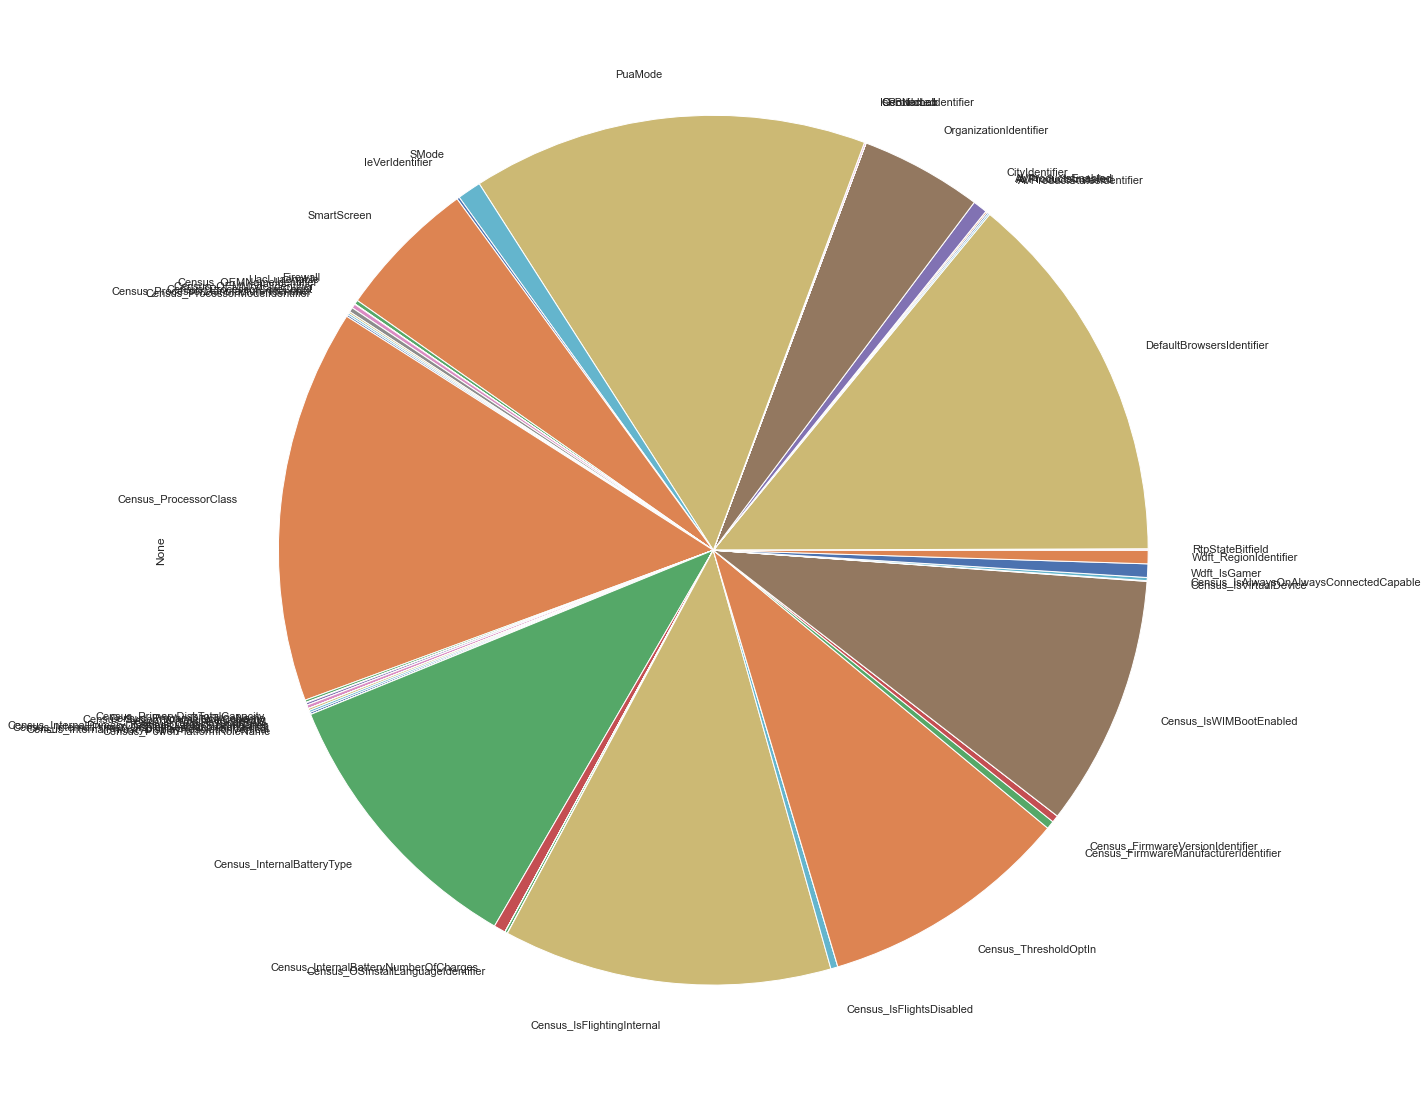

In [7]:
#Not the prettiest pie chart, but it allows us
total.plot.pie(y=holder, figsize=(25,20))
plt.show()

At this point we see various columns that are missing a large percentage of data. The last 9 columns are missing at least 30% or more of their data, with 2 columns missing 99% of their data. I could fill in these values, but given the lack of data this seems like a futile effort. The columns that are missing around 30-35% could potentially be manageable, but there's a significant portion of their data missing and I have decided to remove those as well.

The next thing I decided to examine was the skew of each category. Skew can mess with the distribution. The tail region of skewed data can act as an outlier and have a negative affect on performance. This is particularly bad for regression-based models. Removing skewed data should help improve the performance of this model.

In [8]:
#Skew Analysis
#pd.options.display.float_format = '{:,.4f}'.format
holder_skew = pd.DataFrame([{'column': c, 'skew': train_df[c].value_counts(normalize=True).values[0]} for c in train_df.columns])
holder_skew.sort_values('skew').tail(25)

,column,skew
45,Census_HasOpticalDiskDrive,0.922813
70,Census_FlightRing,0.936580
79,Census_IsAlwaysOnAlwaysConnectedCapable,0.942581
26,IsProtected,0.945624
78,Census_IsPenCapable,0.961929
18,Platform,0.966063
20,OsVer,0.967613
6,RtpStateBitfield,0.973262
11,AVProductsEnabled,0.973984
32,Firewall,0.978583


After doing some research, it seems the common practice is to remove any columns that have a skew of 99% or higher. Skew can affect our model in not so great ways. I have decided to remove nine additional columns (I'm rounding the 98.93 up to 99%). Some columns with high skew were also missing a large portions of data.

Let's now turn our attention to correlation. Using seaborn we can create a headmap with the remaining columns (65). This will allow for a quick visualization and see if we have any crazy correlation going on. High correlation causes trouble, namely multicollinearity. This can cause trouble with estimates of regression. If we find high correlation we'll go ahead and put it on the potential drop list.


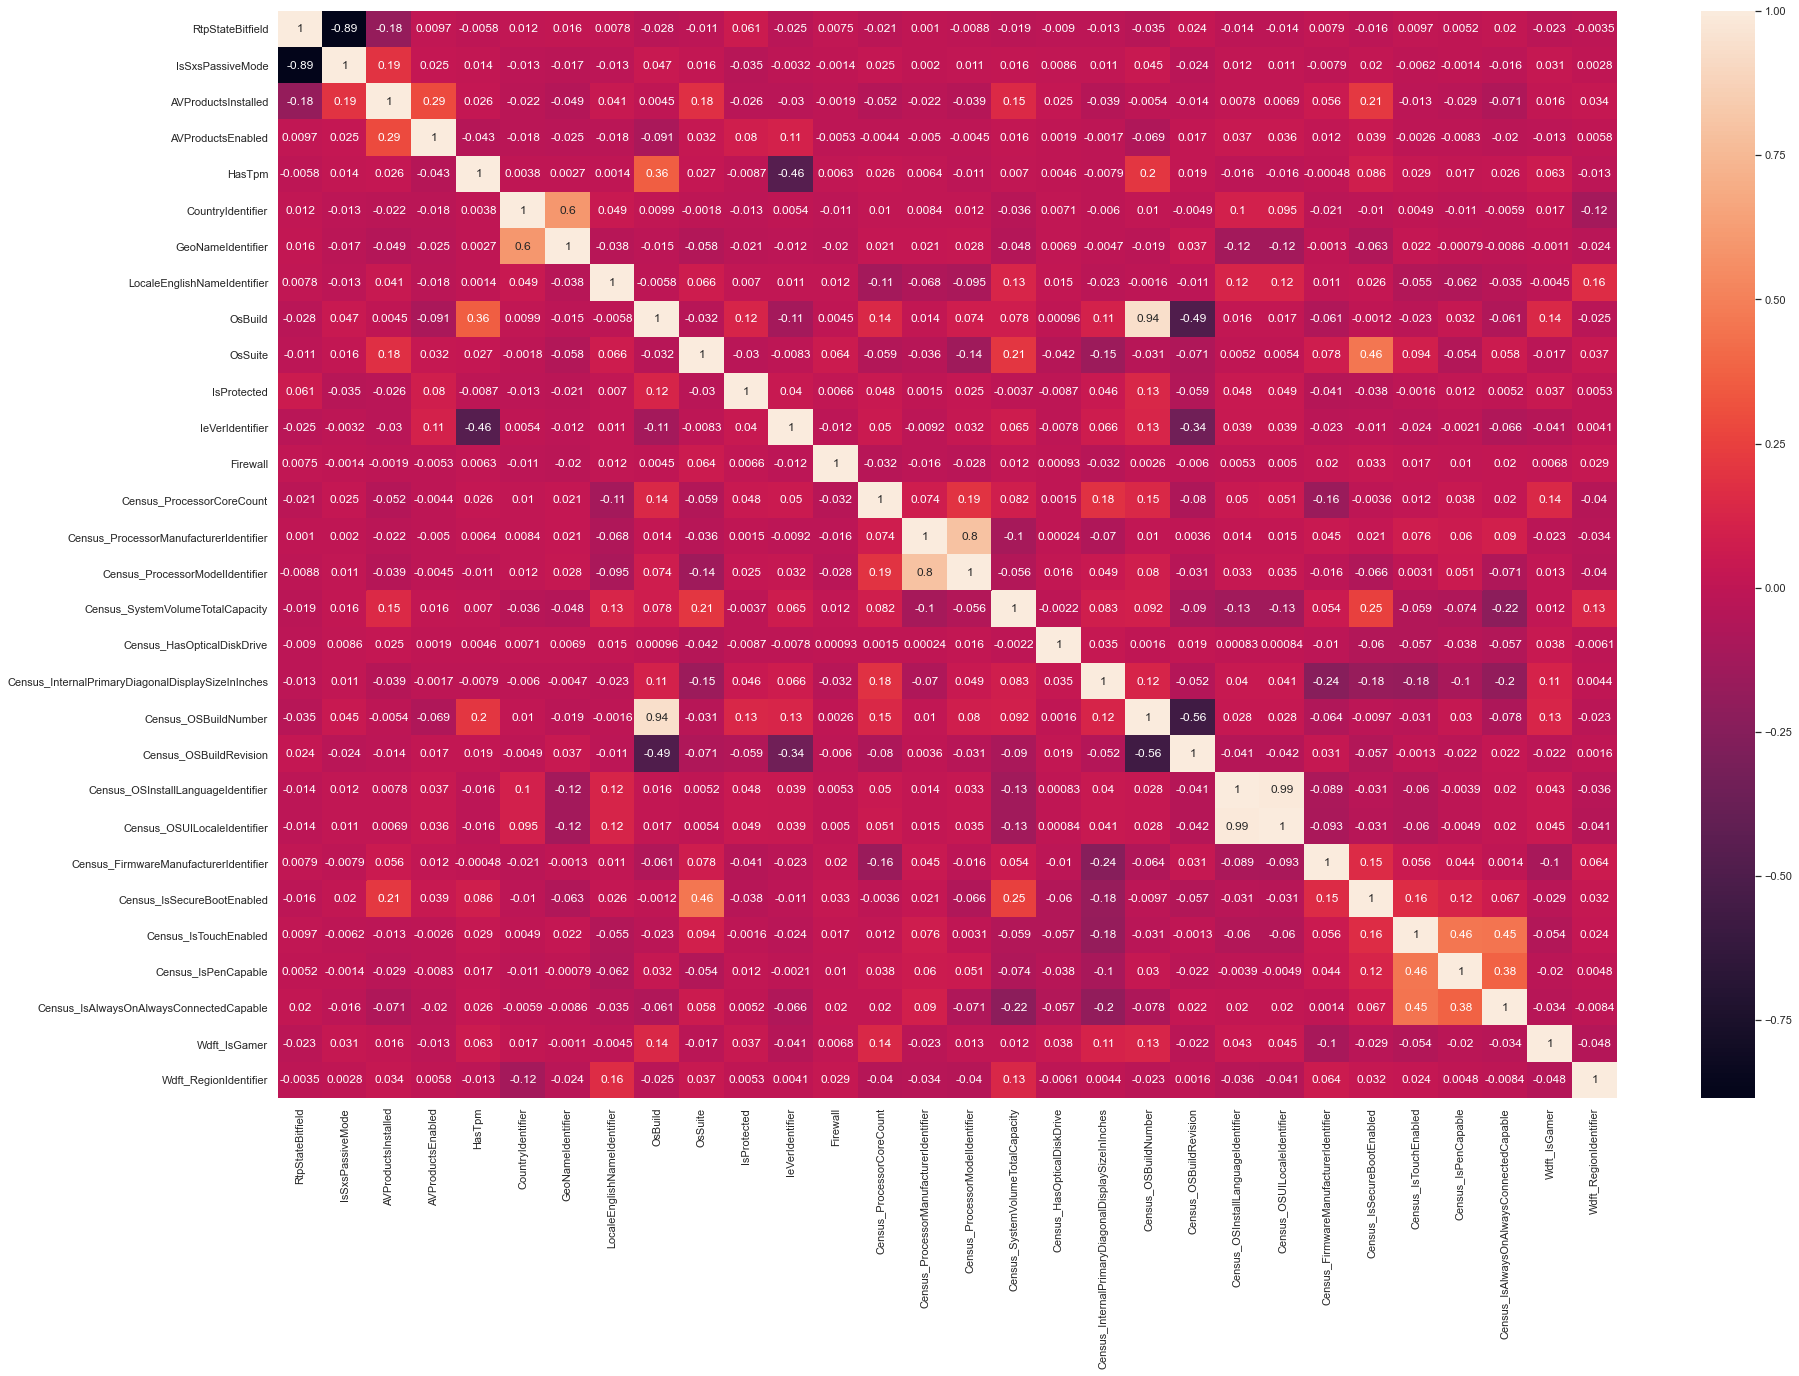

In [9]:
cols_to_use = ['EngineVersion', 'AppVersion',
 'RtpStateBitfield', 'IsSxsPassiveMode',
 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier',
 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier',
 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
 'OsBuildLab', 'SkuEdition', 'IsProtected', 'IeVerIdentifier', 'Firewall',
 'Census_MDC2FormFactor',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion', 'Census_OSArchitecture', 'Census_OSBranch',
 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition',
 'Census_OSSkuName', 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
 'Census_ActivationChannel', 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled', 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
 'Wdft_RegionIdentifier']
plt.figure(figsize=(30,20))
sns.heatmap(train_df[cols_to_use].corr(), annot = True);

According to the heatmap we have high correlation for the following pairs (IsSxPassiveMovde, RtpStateBitfield), (GeoNameIdentifier, CountryIdentifier), (IeVerIdentifier, HasTpm), (HasTpm, OSBuild), (Census_ModelIdentifier, Census_ProcessManufacturerIdentifer), (Census_OSBuildNumber, OSBuild), (Census_OSBuildRevision, OSBuild), (Census_OsBuildVersion, leVerIdentifier), (Census_OSBuildRevision, Census_OsBuildNumber), (Census_OSULocateIdentifier, Census_OSInstallLanguageIdentifier), (Census_IsSecureBootEnabled, OSBuild), (Census_isPenEnabled, Census_IsTouchEnabled), (Census_IsAlwaysonAlwaysConnectedCapable, Census_IsTouchEnabled), (Census_IsAlwaysonAlwaysConnectedCapable, Census_IsPenEnabled). Each of these has varying degrees of correlation, but everythin is above at least a .30. <br/>
<br/>
Between the correlation and graph analysis in the next section I have decided to remove the following columns as a result (RtpStateBitfield, HasTpm, CountryIdentifier, OSBuild, Census_OSInstallLanguageIdentifier, Census_ProcessorManufacturerIdentifier, Census_IsTouchEnabled). These were the most ergregious and should help cut down on correlation thus improving the model.<br/>


The below section is a way to transform data and fill in missing values. I modeled this version after one I found inside the compeition and have credited the original owner. Essentially what happens is it creates a categorical and numeric dictionary that maps and inserts values into the data making it far more useable. Additionally this fills in our missing values and makes them more efficient. This transformation has to take place across both train and test data. *Please note also this process generally takes place right before running the model. I have included it here since I believe it fell into the data clean-up category.

In [ ]:
#Identify categorical and numeric columns. We need to do some transformations and this will make life easier.
category_col = x_train_final.select_dtypes(['category']).columns
numeric_col = x_train_final.select_dtypes(['number', 'bool']).columns

#I utilized a kaggle notebook as a template for this implementation. I had tried to implement a dictionary method like this
#but this is was more efficient.
#https://www.kaggle.com/harmeggels/random-forest-feature-importances/notebook

#Create a categorical and numeric dictionary. For each category and numeric value
#we're going to create a dictionary entry that maps a value to that category entry
#or numeric entry. We're also going to fill in missing values at this point using
#the dictionaries. This shores up the data, creates numeric entries for everything so
#that we can more efficiently utilize that data.
category_dictionary = {}
for i, val in x_train_final[category_col].items():
    category_dictionary[i] = dict([(category, code) for code, category in enumerate(val.cat.categories)])

for i, val in category_dictionary.items():
    x_train_final[i] = x_train_final[i].cat.codes
    x_test_final[i].cat.set_categories(train_2_df[i].cat.categories, inplace=True)
    x_test_final[i] = x_test_final[i].cat.codes

numeric_dictionary = {c: val.median() for c, val in train_df.loc[:, numeric_col].items()}

x_train_final.loc[:, numeric_col] = x_train_final.loc[:, numeric_col].fillna(numeric_dictionary)
x_test_final.loc[:, numeric_col] = x_test_final.loc[:, numeric_col].fillna(numeric_dictionary)

# Primary EDA

I want to preface and say origianlly my data clean up and EDA were combined. While I've attempted to separate them due to the requirements of the rubric we've just received, in many ways they are intertwined.

Below we have a wonderful function that displays both categorical distributions and a break down of infected machines. I absolutely love pie graphs and loved this chart. It helped bring categorical data into more focus and helps finalize decisions for which pieces of data to cut.

In [10]:
#I love pie graphs and the succicentness of this EDA function. It is in my opinion, quite beautiful. I felt like it expressed information perfectly.
#Full credit goes to Robert Kwiatkowski
#https://www.kaggle.com/datark1/malware-prediction-eda
def my_graphs1(col_name, rotation=45, threshold=0.01, explode =-1):
    '''
    This function creates two graphs: categories distribution (pie chart) and fraction of infected machines in each category (bar graph).
    It accepts explode, rotationand thresholf arguments to increase the clarity of the pie chart as well.
    '''
    category = train_df[col_name].unique().tolist()
    totals=[]
    infected=[]
    
    for item in category:
        a = (train_df[col_name]==item).sum()
        totals.append(a)
        infected.append((train_df[train_df[col_name]==item]["HasDetections"]==1).sum()/a)
        
    #creating a summary dataframe
    df = pd.DataFrame({"Total":totals,"Infected": infected}, index=category).sort_values("Total", ascending=False) 
    fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(20,8))
    
    #creating a pie chart with conditional explode option
    threshold = train_df.shape[0]*threshold

    if explode==-1:
        ax[0].pie(df[df["Total"]>threshold]["Total"], labels=df[df["Total"]>threshold].index.values, autopct='%1.1f%%',shadow=False, startangle=rotation, textprops={'fontsize': 15})
    else:
        ax[0].pie(df[df["Total"]>threshold]["Total"], labels=df[df["Total"]>threshold].index.values, autopct='%1.1f%%',shadow=False, startangle=rotation, textprops={'fontsize': 15}, explode=explode)
    ax[0].axis('equal')
    ax[0].set_title(col_name)
    
    #created a sorted bar chart
    df.sort_values("Infected", ascending=False, inplace=True)
    ax[1].set_xticklabels(category,rotation=45, horizontalalignment='right')
    ax[1].set_title('Infected fractions')
    ax[1] = sns.barplot(x=df.index, y="Infected",data=df)
    plt.show()

I ended up going through all the data with this. I won't print out every single graph, but will leave this here as an example of what I used. It provided a breakdown of how dominant certain features were and how spread the infection was amongst the different options.

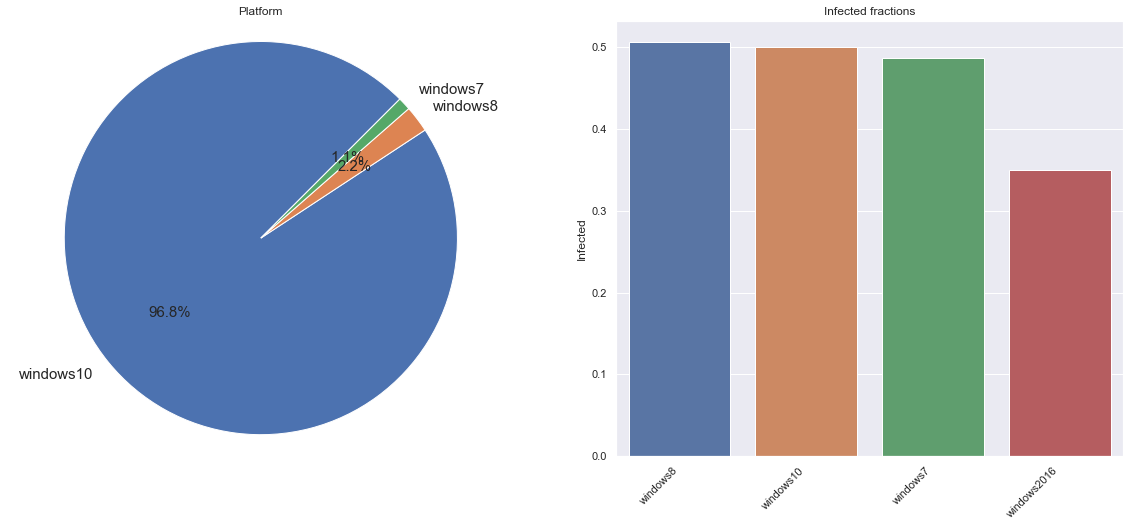

In [11]:
my_graphs1('Platform', 45)

After my data analysis I decided to remove 25 columns. This is fairly significant. I'm hoping to run my analysis with the full data set without columns removed and with columns removeed to see if there is any significant difference. My hope is with the removal of those categories we can create a better model all around and that the removed columns don't diminsh the predictive ability of my model too much.

In [ ]:
train_2_df = train_df.drop(['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_InternalBatteryType', 'Census_ThresholdOptIn',
                            'Census_IsWIMBootEnabled', 'SmartScreen', 'OrganizationIdentifier', 'IsBeta', 'Census_IsFlightsDisabled', 'AutoSampleOptIn', 'SMode', 'Census_IsPortableOperatingSystem',
                           'Census_DeviceFamily', 'UacLuaenable', 'Census_IsVirtualDevice', 'ProductName', 'RtpStateBitfield', 'HasTpm', 'CountryIdentifier', 'OsBuild', 'Census_OSInstallLanguageIdentifier', 
                            'Census_ProcessorManufacturerIdentifier', 'Census_IsTouchEnabled'], axis = 1)


# Attempt at Locating Main Predictors

This original attempt tried to use forward stepwise refinement in the hopes that it could cut down which predictors were the best for the model. The main issue is that this process takes a long time and a lot of ram. Below is a chopped up version of my original model. I was able to locate the first 4 predictors (after about 10 hours of running a vm instance with 64gb of ram). I ran into two major issues, the first was the time contraint. The second was the in order to calculate all predictors against one another would require huge amounts of ram. While I believe the four values I arrived at are still essential in whatever model you end up using, I have to admit the process behind finding them was faulty.

In [ ]:
allowed_factors = [
 'RtpStateBitfield', 'IsSxsPassiveMode',
 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier',
 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier',
 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
  'SkuEdition', 'IsProtected', 'IeVerIdentifier', 'Firewall',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_PowerPlatformRoleName',
 'Census_OSArchitecture', 'Census_OSBranch',
 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition',
 'Census_OSSkuName', 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
 'Census_ActivationChannel', 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled', 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer',
 'Wdft_RegionIdentifier']

In [ ]:
def calc_srr(data, k, Y):
    holdsy = 0
    name = ''
    name2 = ''
    name3 = ''
    name4 = ''
    name5 = ''
      

    if (k >= 5):
        for m in range(len(allowed_factors)):
            formula_entry5 = Y + " ~ " + 'AVProductsInstalled' + " + " + 'EngineVersion' + " + " + 'Census_MDC2FormFactor' + " + " + 'AppVersion' + " + " + allowed_factors[m]
            beta_holder5 = smf.ols(formula=formula_entry5, data=train_2_df).fit()
            rsquared_hold = beta_holder5.rsquared_adj
            if rsquared_hold > holdsy:
                holdsy = rsquared_hold
                name5 = allowed_factors[m]
                            
    return holdsy, name, name2, name3, name4, name5

In [ ]:
calc_srr(train_2_df, 5, 'HasDetections')

In [ ]:
formula_entry5 = 'HasDetections' + " ~ " + 'AVProductsInstalled' + " + " + 'EngineVersion' + " + " + 'Census_MDC2FormFactor' + " + " + 'AppVersion' + " + " + 'Processor'
beta_holder5 = smf.ols(formula=formula_entry5, data=train_2_df).fit()
rsquared_hold = beta_holder5.rsquared_adj
print(rsquared_hold)

# EDA Conclusion

This conclusion includes insights from data clean up and Primary EDA. Overall there is a fair amount of missing and skewed data. I have decided to cut away the majority of this data (25 columns). Admittedly this may not be the best method (25 columns is a fair amount of data). I'm hopeful that that I can run multiple tests to see if having more data is helpful or harmful (Update: Ran tests, it appears I get slightly, ~.07, better results with the removal of the columns).<br/>
<br/>
Through a more efficient data preprocessing system we are able to refine our data and fill in missing values more efficiently than just leaving the values blank.
Through a forward wise refinement process I have determined AVProductsInstalled, EngineVersion, Census_MDC2FormFactor, and AppVersion are critical when determing the model. I wish I could have run a more comprehensive forward stepwise refinement finder, but truthfully it takes too much time and ram.<br/>
<br/>
Overall, after surveying the rest of the data, most of the data looks pretty solid and I can't find a reason to remove it or alter it any further. This now sets up the ability to run some models.

# Model

Originally I attempted to use logistic regression and didn't really see any great results. My first attempt received a .4995 on the grading scale for the compeition. I decided to try out random forest to see if I could gain a higher score and just to try something new. Dr. Kim had mentioned it in piazza and it seemed like a route many people were trying in the competition. 

In [ ]:
#Load Data and set up for models in the future.
x_test_final = test_df.copy() #Make a copy of the df
y_train_final = train_2_df.HasDetections
x_train_final = train_2_df.drop('HasDetections', axis=1) #Drop Has detections

# Logistic Regresion

Logistic regression offered a basic model. The final score was 0.52608, not very impressive but above the original .4995 I had scored previously. This problem does suffer from collinearity. In an attempt to reduce this various correlated columns were removed in order to combat collinearity.

In [ ]:
#Ran relatively fast compared to the other models. All we do is fit the data and predic the probability.
lr = sklearn.linear_model.LogisticRegression()
default_mod = lr.fit(x_train_final, y_train_final.ravel())


yhat_0 = default_mod.predict(x_test_final)
yhat_p = default_mod.predict_proba(x_test_final)

# Linear Discriminate Analysis

Linear discriminant analysis offered a more information analysis of the data. The final score was .546, which was a slight improvement over LR. This problem also can suffer from collinearity. As with LR, there was an attempt to remove various columns in order to reduce the potential of collinearity.

In [ ]:
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda_model = lda.fit(x_train_final, y_train_final)

lda_hat = lda_mod.predict(x_test_final)
lda_pred = lda_model.predict_proba(x_test_final)

# Random Forest

This is a model we haven't used before, but it piqued my curiosity based off Dr. Kim's comments and various notebooks for the competition. Essentially random forest is an ensemble tree-based algorithm. The classifier is a set of decision trees from a randomly selected subset of training data. It combines vote sfrom different decision trees to decide on the final result. I'll talk more about this in the summary/analysis section. However, my highest score for Random Forest was .613.

In [ ]:
#Takes approximately 1.75-2 hours to run
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(n_estimators=30)
model.fit(x_train_final, y_train_final)

prediction = model.predict_proba(x_test_final)

# Test File Creation

In [ ]:
#A setup to create the csv files needed for testing.
import csv

#Fairly straightforward implenentation. We go in, unzip the files, find the relevant probability and then
#match it up to the proper MachineIdentifier. We then create another temporary list and write that to a blank
#csv file. While probably not the most efficient implementation, it gets the job done.
Machine = test_df['MachineIdentifier']
MachineID = []
for i in range(len(test_df)):
    MachineID.append(Machine[i])
    
list1, prediction_holder = zip(*lda_pred)

final = []
final = [list(x) for x in zip(MachineID, prediction_holder)]
    
labels = ['MachineIdentifier', 'HasDetections']

import csv
with open('holder_2.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(labels)
    for i in range(len(prediction_holder)):
        csvwriter.writerow(final[i])

# Summary/Analysis

Preface: Unfortunately I ran into a plethora of issues in regards to printing out information and as a result I have a somewhat limited analysis. My main determinant of success was how the model scored on when uploaded to competition. Given that I was determined to use the full data and not a subset definitely contributed to this problem and in retrospect wish I had taken a subset of data to analyze more in depth. Having said that, the following is the overall analysis that I do have.

Below is a display of the results overal in comparison to one another. I will break down the results in three parts, for each of the major models.

<img src="chart.jpeg"/>

# Logistic Analysis

### Atempt 1
First, attempt 1 is a baseline attempt in order to compare to the other models.
<br/>
### Attempt 2
Overall logistic regression seems to have a somewhat meager affect on the results. The first attempt was without removing the other cleaned up data. As we can see a difference of .0002 was all that took place. The problem of collinearity in the data appears to be present. I hypothesized that by removing highly correlated columns we would see an improvement. Additionally I decided at this point to remove the columns that were excessive amounts of data and columns that were highly skewed. 
### Attempt 3
This attempt paid off. I saw an increase of .0263 which for this competition is quite significant. By accounting for the problem of collinearity I believe it improved my results quite a bit.
### Overall Conclusion
Logistic regression seems to be a decent model for this data, however, it isn't very comprehensive and suffers a number of draw backs. The other models seemed to account for the data loss, the large scale of the data, and the unpredictability of the data far more efficiently then logistic regression. While a good tool, perhaps not the most effective for this competition.

# Linear Discriminant Analysis

After performing my analysis with logistic regression, I wanted to try something somewhat similar to see if I could generate better results. My LDA model offered better results at .546, which is still a sizeable increase over my best logistic regression model. This model was run with the cleaned up data, so collinearity didn't play as much of a role in this particular run. Overall I would say LDA, and logistic regression, aren't well suited to the highly varied data in this data set. No matter what approach you use, or how you clean the data, I feel like you'll never sufficiently create a model that works great.

<img src="chart2.jpeg"/>

# Random Forest Analysis

For this project I really wanted to focus more on an area which we hadn't already covered. Dr. Kim had mentioned random forests in one of her posts and I had see this brought up in various notebooks for the compeititon which piqued my interest. <br/>
<br/>
So before I dive into my analysis, we should describe what random forests are since that hasn't been covered in this class. Essentially random forest is an ensemble tree-based algorithm. The classifier is a set of decision trees from a randomly selected subset of training data. Random forest modeling suffers less from collinearity (though still can suffer from it to an extent), and they offer more options. One of the most interesting aspects of random forests is designating your n-estimators, trees, and how helpful it can be. In general as you increase your n-estimators you get better results, but this diminishes as you go along, and it can take away from the performance of your model as well. It is suggested to use 10,30, or 100. For the purposes of this project I chose 30 as a good go between.<br/>
### Attempt 1
This attempt didn't filter out any columns. The results were still well beyond that LR and LDA could produce. The ability of random forest to predict with this size of data and with missing pieces of data really paid off in terms of this model in comparison to LR and LDA.
### Attempt 2
This attempt removed the columns of data that were identified as potentially problematic during the clean up and EDA phase. As you can see this resulted in a bit of an improvement, but not a massive improvement. I believe removing columns that were highly correlated was the main reason I saw improvements in this attempt as opposed to the previous attempt.
### Attempt 3
This attempt actually happened by mistake. Nothing was changed from attempt 2, however, it is interesting to note there was a .001 increase in the results. As a general note it is interesting to see how we can run with the exact same parameters and still get a differing results. Granted, the result isn't massively different, but there is still some fluctuation.

# Discussion and Conclusion

Overall it appears LR and LDA has some issues when it comes to processing large datasets. Given the variability of the data, there was a fair amount of correlation and lack of data that both of those models don't work well with. Random forest seemed better suited to larger datasets, and also seemed to have less of an issue with missing data in general.<br/>

### What didn't work
I would argue that perhaps the biggest flaw for this project was my ability to effectively transform missing data. Taking out 25 columns is sizeable and truthfully probably had a large negative impact on my results overall. Finding an effective way to transform the data could also have improved results more. Truthfully I wish we had learned more about how to clean up data like this in the class given the constraints of the project, but that's something that I will explore in the future. Dimensionality reduction techniques were something I tried to implement at the beginning of this project but failed. PCA offers a lot of interesting avenues but it was hard for me to effectively implement that, and after a few hours I decided it was in my best interest to try something new. Perhaps the biggest issue I had was the data size. I wanted to tackle a large scale data assignment at least once in the CSPB program and saw this project as an opportunity to do that. In retrospect I probably should have taken a subset of the data and just worked with that. I ended up using a google vm instance with 64gb of data in order to properly gain all results.

### Remodeling/more analysis
Throughout the course of the project I attempted to run my models various times to gauge their proficiency. Given the size of the data some of my models took a long time to run. Random forest takes about 2 hours per iteration which made tweaking that a bit of a process. I tried to change my designs by either adding in more data or removing certain data that was determined to be potentially detrimental to the overall model.

### Ways to improve
If I had more time I would tweak my random forest implementation. There are ways to find the best number of n-estimators, trees, that maximize its performance. I would probably also assess the ood, out of bag, error for the random forest model. During my research I found that account properly for ood can enhance the effectiveness of a random forest model. 
<br/>
<br/>
Additionally I would take more concrete steps into finding an effective way to replace the missing data. There are still columns like PuaMode which are missing 99% of its data that I would still remove, however, some of the other ones can be recovered. Even finding effective ways to replace the values of columns that aren't missing large pieces of data would probably prove to be more effective than what I ended up using.
<br/>
<br/>
Finally I would explore different models. I found that LR and LDA just weren't well suited for this data. Random forest did a much better job, however, I think there might be other models that might be even more effective. It was fun and interesting learning about random forest and I look forward to learning more models in the future.